In [1]:
import librosa
import numpy as np
from skimage.feature import local_binary_pattern, hog
from src.music_recommender.config import Config
from pathlib import Path
from typing import Tuple

In [2]:
cfg = Config()
asp = cfg.paths.audio_spotify

In [3]:
def resample(aud_sr: Tuple[np.ndarray, float], new_sr: int) -> Tuple[np.ndarray, float]:
    aud, sr = aud_sr
    if sr == new_sr:
        return aud, sr
    if aud.ndim == 1:
        res_aud = librosa.resample(aud, orig_sr=sr, target_sr=new_sr)
    else:
        res_aud = np.stack(
            [librosa.resample(channel, orig_sr=sr, target_sr=new_sr) for channel in aud]
        )
    return res_aud, new_sr


def rechannel(
    aud_sr: Tuple[np.ndarray, float], new_ch: int
) -> Tuple[np.ndarray, float]:
    aud, sr = aud_sr
    n_ch = 1 if aud.ndim == 1 else aud.shape[0]
    if n_ch == new_ch:
        return aud_sr
    if new_ch == 1:
        res_aud = np.mean(aud, axis=0, keepdims=True)
    if new_ch == 2:
        res_aud = np.stack([aud, aud])
    else:
        raise ValueError(f"Unsupported number of channels: {new_ch}")
    return res_aud, sr


def load_spectr(
    audio_path: Path,
    n_fft: int = 2048,
    hop_length: int = 512,
    n_mels=40,
) -> Tuple[np.ndarray, float]:
    try:
        aud_sr = librosa.load(audio_path)
        aud_sr = rechannel(aud_sr=aud_sr, new_ch=1)
        aud_sr = resample(aud_sr=aud_sr, new_sr=16000)
        aud, sr = aud_sr
        spect = librosa.feature.melspectrogram(
            y=aud, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        return spect, sr
    except Exception as e:
        raise ValueError(f"no audio here {audio_path} ,error: {e} man")


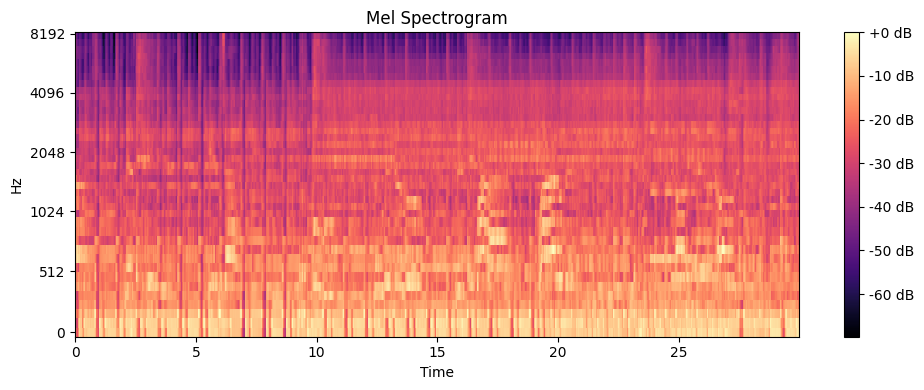

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

spect_sr = load_spectr(asp / "126683.mp3")
spect, sr = spect_sr
spect_db = librosa.power_to_db(spect, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spect_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()


In [22]:
np.histogram(local_binary_pattern(spect, 8, 1, method="uniform").ravel(),bins=256)


/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(array([2287,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 3539,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 2454,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 4996,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 6770,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4817,
           0,    0,    0,    0,    0, 

In [ ]:
def reduce_lbp_patterns(subband_hist:np.ndarray)->np.ndarray:
    representative_patterns = [
        0b00000000,  # Flat (face)
        0b11111111,  # Flat (face)
        0b00001111,  # Edge
        0b11110000,  # Edge
        0b00111100,  # Edge
        0b11000011,  # Edge
        0b00000011,  # Corner
        0b00000110,  # Corner
        0b00001100,  # Corner
        0b00011000,  # Corner
        0b00110000,  # Corner
        0b01100000,  # Corner
        0b11000000,  # Corner
        0b10000001,  # Corner
        0b01111110,  # Edge variation
        0b00111111,  # Edge variation
        0b11111100,  # Edge variation
        0b11111000,  # Edge variation
    ]
    lbp_18=np.zeros(18)
    for code in range(256):
        if subband_hist[code]>0:
            min_dist = 8
            best_idx = 17

            for idx, pattern in enumerate(representative_patterns):
                dist = bin(code ^ pattern).count("1")
                if dist < min_dist:
                        min_dist = dist
                        best_idx = idx
                
            lbp_18[best_idx] += subband_hist[code]
    return lbp_18

In [ ]:
def extract_lbp(spect:np.ndarray, nbr_subband:int, nbr_point:int=8, radius:int=1):
    subband_height = spect.shape[0] // nbr_subband
    lbp_features = []

    for i in range(nbr_subband):
        start = i * subband_height
        end = (i + 1) * subband_height if i < nbr_subband - 1 else spect.shape[0]
        subband = spect[start:end, :]

        lbp_feature, _ = np.histogram(local_binary_pattern(subband, nbr_point, radius, method="uniform"),bins=256,range=(0,256))
        lbp_feature_reduced = reduce_lbp_patterns(lbp_feature)
        lbp_features.append(lbp_feature_reduced)
    return np.concatenate(lbp_features)
        

SyntaxError: invalid syntax (2695817231.py, line 6)